# Comparing Daily to hourly data

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [6]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [7]:
dxx=0.5
dyy=dxx

In [8]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

# Calculating KE

In [9]:
%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.compute();

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 13.8 µs


In [10]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [13]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'



In [14]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [15]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))

In [23]:
%time
uf_h=varf.u.compute();
ut_h=vart.u.compute();

vf_h=varf.v.compute();
vt_h=vart.v.compute();

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 13.8 µs


In [24]:
uf_h,vf_h,_=romspickle.uvw2rho_3d(uf_h,vf_h,uf_h)
uf_h,vf_h=uf_h[:,120:-120,120:800],vf_h[:,120:-120,120:800]

ut_h,vt_h,_=romspickle.uvw2rho_3d(ut_h,vt_h,ut_h)
ut_h,vt_h=ut_h[:,120:-120,120:800],vt_h[:,120:-120,120:800]

In [25]:
with ProgressBar():
    Uf_h=xrft.isotropic_power_spectrum(uf_h,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vf_h=xrft.isotropic_power_spectrum(vf_h,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Ut_h=xrft.isotropic_power_spectrum(ut_h,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    Vt_h=xrft.isotropic_power_spectrum(vt_h,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [26]:
Ekef_h=xr.DataArray(data=0.5*(Uf_h.data + Vf_h.data),coords=({'time_counter':Uf_h.time_counter,'freq_r':Uf_h.freq_r.data}))
Eket_h=xr.DataArray(data=0.5*(Ut_h.data + Vt_h.data),coords=({'time_counter':Uf_h.time_counter,'freq_r':Uf_h.freq_r.data}))

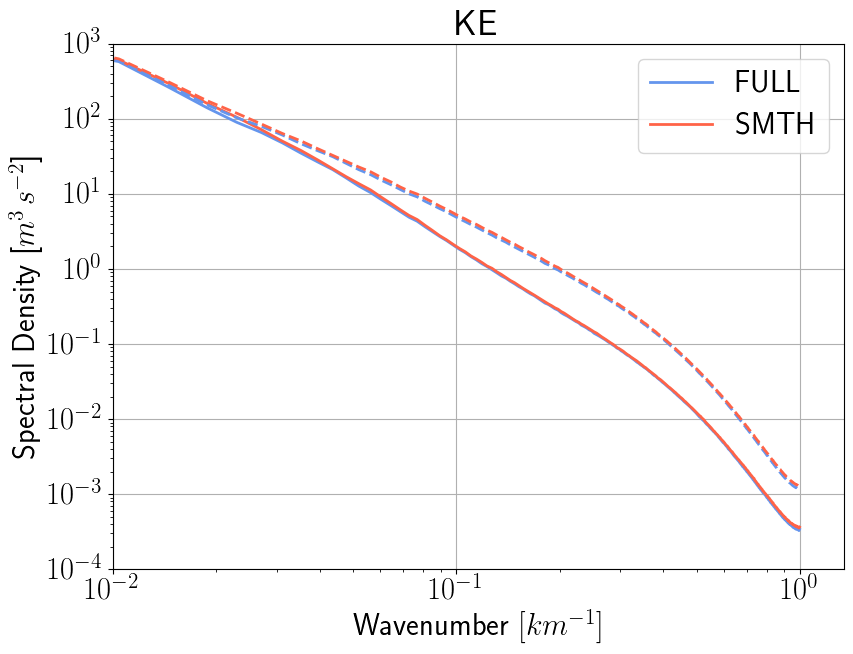

In [37]:
plt.figure(figsize=(9,7))


# k2 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
# E2 = ((1/k2)**2)*(1e-1)

# k3 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
# E3 = ((1/k3)**3)*(1e-3)


# plt.plot(k2,E2,'k--',alpha=0.2)
# plt.text(0.7,0.5e-2,r'$\kappa^{-2}$',weight='normal',alpha=0.2)

# plt.plot(k3,E3,'b--',alpha=0.2)
# plt.text(0.7,5e-2,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.2)



plt.plot(Ekef.freq_r/dxx,Ekef.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(Eket.freq_r/dxx,Eket.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

plt.plot(Ekef_h.freq_r/dxx,Ekef_h.mean(axis=0)/dxx*1e3,linestyle='--',linewidth=2,color='cornflowerblue')
plt.plot(Eket_h.freq_r/dxx,Eket_h.mean(axis=0)/dxx*1e3,linestyle='--',linewidth=2,color='tomato')



plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.title('KE',fontweight='bold')
plt.ylabel(r'Spectral Density [$m^3\,s^{-2}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')

plt.xlim(1e-2,0)
plt.ylim(1e-4,1e3)
plt.tight_layout()

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_SURFACE_KE.png')

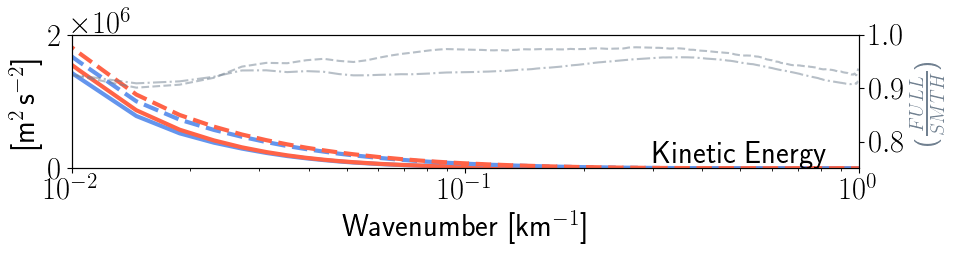

In [36]:
'Ogive graph'

KAf=ogive(Ekef.freq_r/dxx*1e3,np.nanmean(Ekef,axis=0)/dxx*1e3) #in metersss
Kx=Ekef.freq_r/dxx #in Kilometers
KAt=ogive(Eket.freq_r/dxx*1e3,np.nanmean(Eket,axis=0)/dxx*1e3)#in metersss

KAf_h=ogive(Ekef_h.freq_r/dxx*1e3,np.nanmean(Ekef_h,axis=0)/dxx*1e3) #in metersss
Kx_h=Ekef.freq_r/dxx #in Kilometers
KAt_h=ogive(Eket_h.freq_r/dxx*1e3,np.nanmean(Eket_h,axis=0)/dxx*1e3)#in metersss







fig,ax = plt.subplots(figsize=(10,3))
ax.plot((Kx),KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot((Kx),KAt,label='SMTH',linewidth=3,color='tomato')

ax.plot((Kx_h),KAf_h,linestyle='--',linewidth=3,color='cornflowerblue')
ax.plot((Kx_h),KAt_h,linestyle='--',linewidth=3,color='tomato')
# ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')


ax.set_xscale('log')

ax.text(3e-1,0.1e6,'Kinetic Energy')



# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])


ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^2\,$s$^{-2}$]',fontweight='bold')
# ax.set_title(r'KE',fontsize=25)
ax.set_xlim(1e-2,1)
ax.set_ylim(-0.1,2e6)



# ax.legend()

ax2=ax.twinx()
# ax2.plot((Kx),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.plot((Kx_h),((KAf_h)/(KAt_h)),alpha=0.5,linestyle='-.',color='slategrey')


ax2.set_ylim(0.901,1)



ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontweight='bold',fontsize=20,color='slategrey')
ax2.set_xscale('log')
ax2.set_yticks([0.80,0.90,1])
ax2.set_ylim(0.75,1)
plt.tight_layout()